### Prepare data from the CESM2-LE

In [1]:
import intake
import matplotlib.pyplot as plt
import xarray as xr
from distributed import Client
from ncar_jobqueue import NCARCluster
import dask
import numpy as np
import pop_tools
import warnings
warnings.filterwarnings('ignore')
import cartopy
import cartopy.crs as ccrs
import utils
from glob import glob
import numpy as np

In [2]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=2,
        memory='20 GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=20GB',
        project='NCGD0011',
        walltime='03:00:00',
        interface='ext',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

In [3]:
cluster, client = get_ClusterClient()
cluster.scale(12) 
client

Client Scheduler: tcp://128.117.208.103:38109 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kristenk/proxy/39521/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [4]:
catalog = intake.open_esm_datastore(
    '/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cesm2-le.json'
)

In [5]:
catalog.df.experiment.unique()

array(['historical', 'ssp370'], dtype=object)

In [6]:
catalog

,unique
component,6
stream,26
case,200
member_id,100
variable,1906
start_time,157
end_time,180
time_range,163
long_name,1800
units,184


### Get NPP ds

#### historical part

In [7]:
subset = catalog.search(component='ocn',
                        variable='IFRAC',
                        experiment='historical', #'ssp370',
                        forcing_variant='cmip6',
                       )

In [8]:
with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    dsets = subset.to_dataset_dict()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream.forcing_variant.variable'


In [9]:
ds_ice_hist = dsets['ocn.historical.pop.h.cmip6.IFRAC'] #dsets['ocn.ssp370.pop.h.cmip6.photoC_TOT_zint']
ds_ice_hist['time']= ds_ice_hist.time_bound.compute().mean(dim="d2")

In [10]:
keep_vars=['z_t','z_t_150m','time_bound','dz','TLAT','TLONG','time'] + ['IFRAC']

ds_ice_hist = ds_ice_hist.drop([v for v in ds_ice_hist.variables if v not in keep_vars])

In [11]:
ds_ice_hist.time[840]

<xarray.DataArray 'time' ()>
array(cftime.DatetimeNoLeap(1920, 1, 16, 12, 0, 0, 0), dtype=object)
Coordinates:
    time     object 1920-01-16 12:00:00

In [12]:
ds_ice_hist.time[1200]

<xarray.DataArray 'time' ()>
array(cftime.DatetimeNoLeap(1950, 1, 16, 12, 0, 0, 0), dtype=object)
Coordinates:
    time     object 1950-01-16 12:00:00

In [13]:
ds_ice_hist = ds_ice_hist.isel(time=slice(840,1200))

In [14]:
%%time

ds_by_mon_dict = {}

ds_by_mon_dict['jun'] = ds_ice_hist.sel(time = np.in1d(ds_ice_hist['time.month'], 6)).compute()
ds_by_mon_dict['jul'] = ds_ice_hist.sel(time = np.in1d(ds_ice_hist['time.month'], 7)).compute()
ds_by_mon_dict['aug'] = ds_ice_hist.sel(time = np.in1d(ds_ice_hist['time.month'], 8)).compute()

CPU times: user 2.28 s, sys: 2.72 s, total: 4.99 s
Wall time: 16.4 s


In [15]:
ds_by_mon_dict.keys()

dict_keys(['jun', 'jul', 'aug'])

In [16]:
ds_by_mon_dict['jun']

<xarray.Dataset>
Dimensions:     (d2: 2, member_id: 50, nlat: 384, nlon: 320, time: 30, z_t: 60, z_t_150m: 15)
Coordinates:
  * z_t         (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m    (z_t_150m) float32 500.0 1.5e+03 2.5e+03 ... 1.35e+04 1.45e+04
    TLONG       (nlat, nlon) float64 320.6 321.7 322.8 ... 318.9 319.4 319.8
    TLAT        (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
  * time        (time) object 1920-06-16 00:00:00 ... 1949-06-16 00:00:00
Dimensions without coordinates: d2, member_id, nlat, nlon
Data variables:
    dz          (z_t) float32 1e+03 1e+03 1e+03 ... 2.499e+04 2.5e+04 2.5e+04
    time_bound  (time, d2) object 1920-06-01 00:00:00 ... 1949-07-01 00:00:00
    IFRAC       (member_id, time, nlat, nlon) float32 nan nan nan ... nan nan
Attributes:
    contents:                Diagnostic and Prognostic Variables
    time_period_freq:        month_1
    NCO:                     netCDF Operators version 4.9.5 (Homepage = http:...
    history:                 none\nnone\nThu Dec  9 16:32:11 2021: ncks -O -F...
    source:                  CCSM POP2, the CCSM Ocean Component
    revision:                $Id$
    intake_esm_varname:      ['IFRAC']
    model_doi_url:           https://doi.org/10.5065/D67H1H0V
    cell_methods:            cell_methods = time: mean ==> the variable value...
    Conventions:             CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf...
    calendar:                All years have exactly  365 days.
    intake_esm_dataset_key:  ocn.historical.pop.h.cmip6.IFRAC

### Make JJA mean

In [17]:
ds_mean = (ds_by_mon_dict['jun'].mean(dim='time') + ds_by_mon_dict['jul'].mean(dim='time') + ds_by_mon_dict['aug'].mean(dim='time'))/3

In [18]:
ds_mean = ds_mean.mean(dim='member_id')

### Get grid info

In [19]:
ds_grid = pop_tools.get_grid('POP_gx1v7')
lats = ds_grid.TLAT
lons = ds_grid.TLONG
area = ds_grid.TAREA
lons_norm = utils.normal_lons(lons)

In [20]:
ones = np.full((384,320),1,dtype=int)
ones = xr.DataArray(ones,dims=('nlat','nlon'))
ones = ones.where(ds_grid.REGION_MASK>0)



In [22]:
ds_siz_mask2 = xr.Dataset()
ds_siz_mask2['SIZ'] = ones.where(ds_mean.IFRAC > 0.15).where(lats < 0)

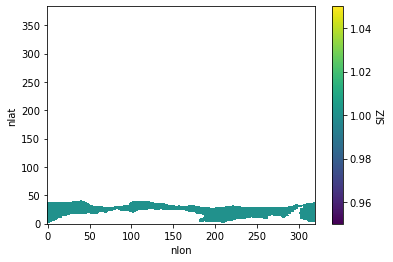

In [23]:
ds_siz_mask2['SIZ'].plot()

In [24]:
ds_siz_mask2.to_netcdf('/glade/u/home/kristenk/antarc_marine_pred_work/TOE/SIZ_mask_1920-50-CESM2LE_15percentJJA.nc',mode='w')

In [25]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError
